In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,0,3
1,2,upgraded card tell agent upgrade anniversary d...,3,1
2,10,chase card report however fraudulent applicati...,6,2
3,11,try book ticket come across offer apply toward...,3,3
4,14,grand son give check deposit chase account fun...,4,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,3,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,2,2
21070,78311,flawless credit chase credit card chase freedo...,7,3


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(21072, 16306)

In [4]:
vectorizer.get_feature_names_out()

array(['aad', 'aba', 'abandon', ..., 'zoom', 'zur', 'zyk'], dtype=object)

# Data Partition

In [5]:
# save vectorizer
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"vectorizer.pkl"), "wb") as f:
    dump(vectorizer, f, protocol=5)

In [6]:
# split into training set and validation set
from sklearn.model_selection import train_test_split

y = df[['topic_lda','priority']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 16306)
(4215, 16306)
(16857, 2)
(4215, 2)


# Model Building

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

lr = MultiOutputClassifier(LogisticRegression(multi_class ="multinomial",random_state=42)).fit(X_train, y_train)

C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [9]:
lr.score(X_test,y_test)

0.6467378410438909

In [10]:
lr_preds = lr.predict(X_test)
lr_preds

array([[0, 3],
       [5, 3],
       [1, 1],
       ...,
       [3, 3],
       [6, 3],
       [1, 3]], dtype=int64)

In [11]:
lr_preds[:, 0]

array([0, 5, 1, ..., 3, 6, 1], dtype=int64)

In [12]:
lr_preds[:, 1]

array([3, 3, 1, ..., 3, 3, 3], dtype=int64)

# Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.8759193357058126
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       857
           1       0.90      0.94      0.92       463
           2       0.91      0.69      0.78       200
           3       0.88      0.90      0.89       393
           4       0.87      0.91      0.89       628
           5       0.87      0.81      0.84       281
           6       0.88      0.90      0.89       508
           7       0.87      0.87      0.87       474
           8       0.89      0.80      0.84       411

    accuracy                           0.88      4215
   macro avg       0.88      0.86      0.87      4215
weighted avg       0.88      0.88      0.87      4215



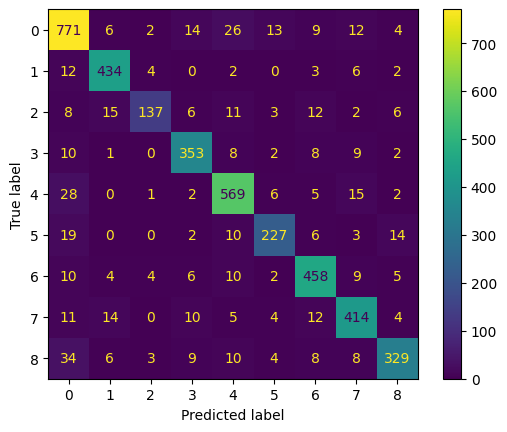

In [14]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=lr_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], lr_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=lr_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.7345195729537367
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.62      0.67       802
           2       0.62      0.55      0.58      1282
           3       0.80      0.89      0.84      2131

    accuracy                           0.73      4215
   macro avg       0.71      0.69      0.70      4215
weighted avg       0.73      0.73      0.73      4215



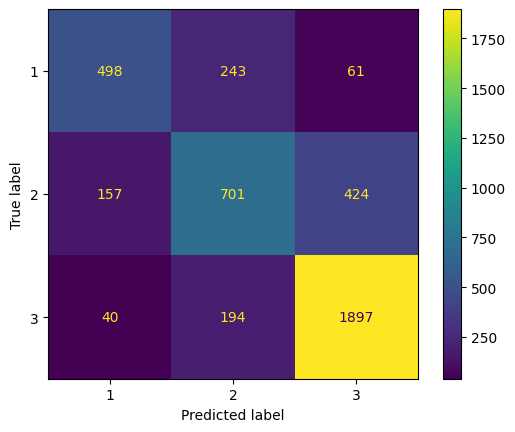

In [15]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=lr_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], lr_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=lr_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [17]:
param_grid = {
    'estimator__penalty':[None,'l2'],
    'estimator__C': [0.5, 1, 5, 10, 20, 25, 30, 40, 50, 100],  # Regularization strength parameter
    'estimator__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']  # Solvers to consider
}

In [18]:
grid_search = GridSearchCV(
    estimator=MultiOutputClassifier(LogisticRegression(multi_class ="multinomial",random_state=42)), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=LogisticRegression(multi_class='multinomial',
                                                                          random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.5, 1, 5, 10, 20, 25, 30, 40, 50,
                                          100],
                         'estimator__penalty': [None, 'l2'],
                         'estimator__solver': ['newton-cg', 'sag', 'saga',
                                               'lbfgs']},
             verbose=2)

In [20]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [21]:
bestlr = grid_search.best_estimator_

In [22]:
best_lr_score = bestlr.score(X_test, y_test)
print("Best model accuracy:", best_lr_score)

Best model accuracy: 0.6647686832740214


# Evaluation After Tuning

In [23]:
bestlr_preds = bestlr.predict(X_test)

================ Ticket Category =================
Accuracy:  0.8863582443653618
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       857
           1       0.91      0.94      0.93       463
           2       0.89      0.74      0.81       200
           3       0.89      0.91      0.90       393
           4       0.88      0.90      0.89       628
           5       0.86      0.85      0.86       281
           6       0.89      0.91      0.90       508
           7       0.87      0.87      0.87       474
           8       0.91      0.82      0.86       411

    accuracy                           0.89      4215
   macro avg       0.89      0.87      0.88      4215
weighted avg       0.89      0.89      0.89      4215



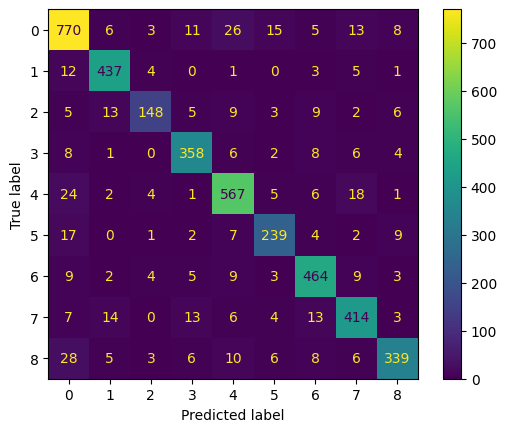

In [24]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestlr_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestlr_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestlr_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.7499406880189798
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.65      0.68       802
           2       0.62      0.61      0.62      1282
           3       0.84      0.87      0.85      2131

    accuracy                           0.75      4215
   macro avg       0.72      0.71      0.72      4215
weighted avg       0.75      0.75      0.75      4215



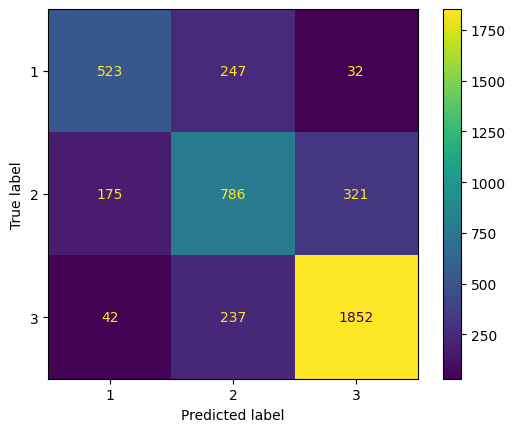

In [25]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestlr_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestlr_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestlr_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [26]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"tuned_lr.pkl"), "wb") as f:
    dump(bestlr, f, protocol=5)